# German Political Speeches Sentiment Analysis
#### Riley Hesbacher

#### A bit about my project
I'm looking at sentiment accross German political parties. To do this, I'm using spacy SentiWS, a german sentiment analyzer, and a corpus of German political speeches.

### Table of Contents
- [Data Collection and Addition](#Data-Collection-and-Addition)
- [Sentiment Analysis](#Sentiment-Analysis)
- [Word Analysis](#Word-Analysis)
- [Diachronic Analysis](#Diachronic-Analysis)
- [Summary](#Summary)

## Data Collection and Addition

The data I use below is under the license linked here: https://github.com/Data-Science-for-Linguists-2024/German-Political-Speeches-Sentiment-Analysis/blob/main/data-samples/LICENSE.txt

The data was originally from: 

Barbaresi, Adrien (2018). A corpus of German political speeches from the 21st century, Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018), European Language Resources Association (ELRA), pp. 792–797.

For my data, I started by taking the xml files from my corpus and turning them into dataframes for easier use. Then, I looked through the data for missing values, getting a feel for the data, etc. Then I added values to the data and dropped unnecessary sections. I started some analysis of the sentiment across parties and offices.

In [1]:
#Import all the necessary libraries
import pandas as pd
import nltk
import spacy
from spacy_sentiws import spaCySentiWS
from  spacy.lang.de.stop_words import STOP_WORDS
import statistics
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import sklearn              
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import scipy
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
#reading in the files
f = open("data/Bundespräsidenten.xml", "r")
BundesPr = pd.read_xml(f)
BundesPr.head()

,person,titel,datum,ort,untertitel,url,anrede,rohtext
0,Joachim Gauck,Begegnungsreise mit dem Diplomatischen Korps,2016-05-02,Saarbrücken,Bundespräsident Joachim Gauck hat am 2. Mai be...,http://www.bundespraesident.de/SharedDocs/Rede...,NaN,Wie viele Botschafterinnen und Botschafter hab...
1,Joachim Gauck,Empfang des slowakischen Präsidenten,2014-02-26,Schloss Bellevue,Bundespräsident Joachim Gauck hat am 26. Febru...,http://www.bundespraesident.de/SharedDocs/Rede...,NaN,"Besuche sind eine schöne Gelegenheit, Gemeinsa..."
2,Horst Köhler,Grußwort von Bundespräsident Horst Köhler an d...,2009-03-13,Madrid,NaN,http://www.bundespraesident.de/SharedDocs/Rede...,NaN,"Majestät, ich danke Ihnen für Ihre Worte des M..."
3,Joachim Gauck,Gedenkkonzert des Brandenburgischen Staatsorch...,2013-11-09,NaN,Der Bundespräsident hat am 9. November bei ein...,http://www.bundespraesident.de/SharedDocs/Rede...,NaN,Wir wollen heute Abend gedenken. Wir gedenken ...
4,Horst Köhler,Grußwort von Bundespräsident Horst Köhler bei ...,2009-12-06,Berlin,NaN,http://www.bundespraesident.de/SharedDocs/Rede...,NaN,Herzlich willkommen in Schloss Bellevue. Meine...


I can already see that some colums have NaN values, but on the surface, it's none of the columns I'm concerned with. Let's check them all to make sure.

In [3]:
BundesPr.count()

person        2045
titel         2045
datum         2045
ort           1774
untertitel     609
url           2045
anrede         224
rohtext       2045
dtype: int64

So we can see that 3 columns have NaN values. They are 'ort'(place), 'untertitel'(subtitle/decription), and 'anrede'(address). None of these are the columns I'm concerned with for my analysis, so at least for now, I will be leaving them as is. 
Lets look at the other files!

In [4]:
f = open("data/Bundesregierung.xml", "r")
BundesReg = pd.read_xml(f)
BundesReg.head()

,person,titel,datum,untertitel,url,anrede,rohtext,ort
0,Gerhard Schröder,Rede des Bundeskanzlers zur Eröffnung der 52. ...,2002-02-06,"Man kann diese Filmfestspiele nicht eröffnen, ...",http://archiv.bundesregierung.de/bpaexport/red...,"Sehr geehrte Frau Nair, liebe Mitglieder der J...","es ist angekündigt worden, man sollte im Beruf...",None
1,Julian Nida-Rümelin,Redebeitrag von Staatsminister Nida-Rümelin in...,2002-02-01,"""Ich bin der Auffassung, wir müssen nicht nur ...",http://archiv.bundesregierung.de/bpaexport/red...,Meine sehr geehrten Damen und Herren!,"Frau Präsidentin! An Sie gerichtet, Herr Börn...",None
2,Gerhard Schröder,Interview mit Bundeskanzler Schröder in 'Berli...,2002-04-14,In dem Interview äußert sich Bundeskanzler Sch...,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Frage (Peter Hahne): Bevor wir uns über den Au...,None
3,Gerhard Schröder,Rede von Bundeskanzler Gerhard Schröder bei de...,2005-03-08,Der Kampf gegen die Arbeitslosigkeit ist eine ...,http://archiv.bundesregierung.de/bpaexport/red...,Herr Ministerpräsident! Lieber Herr Dr. Bernot...,"Einen Satz von Ihnen, Herr Dr. Bernotat, habe ...",None
4,Gerhard Schröder,Rede von Bundeskanzler Gerhard Schröder auf de...,2000-05-04,NaN,http://archiv.bundesregierung.de/bpaexport/red...,"Sehr geehrter Herr Professor Landfried, sehr ...",diese Jahresversammlung der Hochschulrektorenk...,None


In [5]:
f = open("data/Bundestagspräsidenten.xml", "r")
BTagPr = pd.read_xml(f)
BTagPr.head()

,person,titel,datum,ort,untertitel,url,anrede,rohtext
0,Norbert Lammert,Deutscher Bundestag - Laudatio zur Verleihung ...,2011-02-12,NaN,NaN,https://www.bundestag.de/parlament/praesidium/...,NaN,"""Der du von dem Himmel bist,Alle Freud und Sch..."
1,Norbert Lammert,Deutscher Bundestag - Rede des Bundestagspräsi...,2009-01-13,NaN,NaN,https://www.bundestag.de/parlament/praesidium/...,NaN,"Sehr geehrter Herr Vorsitzender, lieber Peter ..."
2,Norbert Lammert,Deutscher Bundestag - Rede des Bundestagspräsi...,2009-10-27,NaN,NaN,https://www.bundestag.de/parlament/praesidium/...,NaN,Sehr geehrter Herr Bundespräsident! Verehrte G...
3,Norbert Lammert,Rede anlässlich der Entgegennahme des Georg-S...,17. November 2011,NaN,NaN,NaN,NaN,"Sehr geehrter Herr Präsident, lieber Wolfgang ..."
4,Norbert Lammert,Deutscher Bundestag - Rede des Bundestagspräsi...,2007-01-29,NaN,NaN,https://www.bundestag.de/parlament/praesidium/...,NaN,Sehr geehrter Herr Bundespräsident!Verehrte Fr...


In [6]:
f = open("data/AuswärtigesAmt.xml", "r")
AusAmt = pd.read_xml(f)
AusAmt.head()

,person,titel,datum,ort,untertitel,url,anrede,rohtext
0,Cornelia Pieper,"Rede Staatsministerin Pieper: ""150 Jahre Wisse...",2010-10-14,NaN,"""150 Jahre Wissenschaftsbeziehungen Deutschlan...",http://www.auswaertiges-amt.de/DE/Infoservice/...,"Sehr geehrter Herr Präsident Kajiyama,meine Da...",Ich freue mich sehr über den warmherzigen Empf...
1,Cornelia Pieper,Rede von Staatsministerin Cornelia Pieper im D...,2011-06-30,NaN,Rede von Staatsministerin Cornelia Pieper im D...,http://www.auswaertiges-amt.de/DE/Infoservice/...,Liebe Kolleginnen und Kollegen!,"Ich begrüße es, dass wir heute über die weiter..."
2,Guido Westerwelle,Rede von Guido Westerwelle im Deutschen Bundes...,2010-05-21,NaN,Rede von Bundesaußenminister Guido Westerwelle...,http://www.auswaertiges-amt.de/DE/Infoservice/...,NaN,"Frau Präsidentin!\nHerr Kollege Gabriel, Ihre ..."
3,Frank-Walter Steinmeier,Rede von Außenminister Steinmeier anlässlich d...,2014-11-15,NaN,Rede von Außenminister Steinmeier anlässlich d...,http://www.auswaertiges-amt.de/DE/Infoservice/...,"Sehr geehrte Damen und Herren,",ich sage Dank für die Einladung und habe Respe...
4,Guido Westerwelle,Rede von Außenminister Westerwelle vor der Ver...,2010-11-02,NaN,Rede von Außenminister Westerwelle vor der Ver...,http://www.auswaertiges-amt.de/DE/Infoservice/...,"Sehr geehrte Damen und Herren,",zunächst möchte ich mich sehr herzlich bei Ihn...


I would like to merge all of these dataframes, so I can look at the patterns accross them all, but I do want to know which they came from to keep track. So I'm going to add a column for 'amt'(government office) to mark the file origin of the speaker which is based on what office they are from. 

In [7]:
BundesPr.insert(7, "amt", "Bundespräsident")
BTagPr.insert(7, "amt", "Bundestagspräsident")
AusAmt.insert(7, "amt", "AuswärtigesAmt")
BundesReg.insert(6, "amt", "Bundesregierung")

In [8]:
BundesReg['person'].unique()

array(['Gerhard Schröder', 'Julian Nida-Rümelin', 'Christina Weiss',
       'Frank-Walter Steinmeier', 'Michael Naumann', 'Hans Martin Bury',
       'Otto Graf Lambsdorff', 'Peter Struck', 'Joschka Fischer',
       'Rolf Schwanitz', 'Waldemar Ritter', 'Edelgard Bulmahn',
       'Jürgen Trittin', 'k.A.', 'Friedrich Merz', 'Rudolf Scharping',
       'Renate Schmidt', 'Brigitte Zypries', 'Christine Bergmann',
       'Brigitte Sauzay', 'Heidemarie Wieczorek-Zeul',
       'Matthias Platzeck', 'Béla Anda', 'Werner Müller',
       'Herta Däubler-Gmelin', 'Angela Merkel', 'Bernd Neumann',
       'Ursula von der Leyen', 'Thomas de Maizière', 'Peer Steinbrück',
       'Michael Glos', 'Maria Böhmer', 'Franz Müntefering',
       'Wolfgang Schäuble', 'Franz Josef Jung', 'Sigmar Gabriel',
       'Hans Bernhard Beus', 'Hildegard Müller', 'Hermann Gröhe',
       'Ronald Pofalla', 'Joachim Gauck', 'Roman Herzog', 'Ilse Aigner',
       'Monika Grütters', 'Aydan Özoğuz', 'Helmut Kohl'], dtype=object)

I realized that some speakers are unknown, but they are not marked as NaN. Instead it's 'k.A' for 'keine Ahnung'(no idea). I decided to get rid of k.A. value rows because there arent many(only 66 across over 6000 rows), and they wont be helpful for most of my analysis. 

In [9]:
BundesReg.loc[BundesReg['person'] == 'k.A.']

,person,titel,datum,untertitel,url,anrede,amt,rohtext,ort
272,k.A.,"""Nur gemeinsam werden wir es schaffen"". Aufgab...",2000-06-09,NaN,http://archiv.bundesregierung.de/bpaexport/red...,"Sehr geehrter Herr Dr. Hanusch, sehr geehrte D...",Bundesregierung,Veranstaltung im Rahmen der evangelischen Akad...,None
378,k.A.,Das Archiv unterdrückter Literatur in der DDR,2005-04-13,Am 13. April 2005 wurde das Archiv unterdrückt...,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,am Wochenende habe ich ein Interview mit einer...,None
636,k.A.,"Rede auf dem ""Zeitungstag"" des Bundesverbandes...",1999-06-15,NaN,http://archiv.bundesregierung.de/bpaexport/red...,"Meine Damen und Herren,",Bundesregierung,"wenn ich das richtig sehe, ist dies das letzte...",None
659,k.A.,Rede anlässlich der Arbeitstagung des Goethe-I...,1999-09-27,NaN,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,Zunächst möchte ich mich ganz herzlich für die...,None
674,k.A.,Rede bei der Hypothekenbank in Essen am 8. Nov...,1999-11-08,NaN,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,Kultur in Deutschland wird von Politikern meis...,None
693,k.A.,Auf dem Weg in die Berliner Republik.Rede am 1...,1999-11-17,NaN,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,"Die kleine Bankettfrage des vorigen Herbstes, ...",None
703,k.A.,Wirtschaftliche Aspekte der Kulturpolitik bei ...,1999-11-22,NaN,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,Kultur ist der Name für alle Formen von Zweife...,None
710,k.A.,Rede anläßlich der Beiratssitzung Süd der Deut...,1999-11-29,NaN,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,ich darf mich zunächst einmal recht herzlich b...,None
860,k.A.,Auftaktveranstaltung des Deutsch-Polnischen Ja...,2005-05-08,Am 8. Mai 2005 machten die Teilnehmer an der K...,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,eigentlich möchte man jetzt nur noch ausrufen:...,None
1095,k.A.,Grußwort,2007-04-04,"am Mittwoch, 4. April 2007 in Torgau (Schloss ...",http://www.bundesregierung.de/nn_914560/Conten...,"Sehr verehrte Frau Bürgermeisterin, sehr geehr...",Bundesregierung,"es ist mir eine Freude, heute zu der Eröffnung...",None


In [10]:
#reordering columns for ease
BundesPr = BundesPr[['person', 'datum', 'titel', 'amt', 'url', 'rohtext', 'ort', 'untertitel', 'anrede']]
BundesReg = BundesReg[['person', 'datum', 'titel', 'amt', 'url', 'rohtext', 'ort', 'untertitel', 'anrede']]
BTagPr = BTagPr[['person', 'datum', 'titel', 'amt', 'url', 'rohtext', 'ort', 'untertitel', 'anrede']]
AusAmt = AusAmt[['person', 'datum', 'titel', 'amt', 'url', 'rohtext', 'ort', 'untertitel', 'anrede']]

In [11]:
#Let's put them all together!
speeches = pd.concat([BundesPr, BundesReg, BTagPr, AusAmt])
speeches.head()

,person,datum,titel,amt,url,rohtext,ort,untertitel,anrede
0,Joachim Gauck,2016-05-02,Begegnungsreise mit dem Diplomatischen Korps,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wie viele Botschafterinnen und Botschafter hab...,Saarbrücken,Bundespräsident Joachim Gauck hat am 2. Mai be...,NaN
1,Joachim Gauck,2014-02-26,Empfang des slowakischen Präsidenten,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Besuche sind eine schöne Gelegenheit, Gemeinsa...",Schloss Bellevue,Bundespräsident Joachim Gauck hat am 26. Febru...,NaN
2,Horst Köhler,2009-03-13,Grußwort von Bundespräsident Horst Köhler an d...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Majestät, ich danke Ihnen für Ihre Worte des M...",Madrid,NaN,NaN
3,Joachim Gauck,2013-11-09,Gedenkkonzert des Brandenburgischen Staatsorch...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wir wollen heute Abend gedenken. Wir gedenken ...,NaN,Der Bundespräsident hat am 9. November bei ein...,NaN
4,Horst Köhler,2009-12-06,Grußwort von Bundespräsident Horst Köhler bei ...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Herzlich willkommen in Schloss Bellevue. Meine...,Berlin,NaN,NaN


In [12]:
#Let's delete the 'k.A.' rows
speeches = speeches.drop(speeches[speeches['person'] == 'k.A.'].index)

In [13]:
#Lets delete some unnecessary columns
speeches = speeches.drop(columns=['ort', 'untertitel','anrede'])
speeches.head()

,person,datum,titel,amt,url,rohtext
0,Joachim Gauck,2016-05-02,Begegnungsreise mit dem Diplomatischen Korps,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wie viele Botschafterinnen und Botschafter hab...
1,Joachim Gauck,2014-02-26,Empfang des slowakischen Präsidenten,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Besuche sind eine schöne Gelegenheit, Gemeinsa..."
2,Horst Köhler,2009-03-13,Grußwort von Bundespräsident Horst Köhler an d...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Majestät, ich danke Ihnen für Ihre Worte des M..."
3,Joachim Gauck,2013-11-09,Gedenkkonzert des Brandenburgischen Staatsorch...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wir wollen heute Abend gedenken. Wir gedenken ...
4,Horst Köhler,2009-12-06,Grußwort von Bundespräsident Horst Köhler bei ...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Herzlich willkommen in Schloss Bellevue. Meine...


In [14]:
#Time to add the political party of each speaker
#I'm also going to add gender at the same time to save time
speeches['person'].unique()

array(['Joachim Gauck', 'Horst Köhler', 'Christian Wulff', 'Johannes Rau',
       'Roman Herzog', 'Richard von Weizsäcker', 'Gerhard Schröder',
       'Julian Nida-Rümelin', 'Christina Weiss',
       'Frank-Walter Steinmeier', 'Michael Naumann', 'Hans Martin Bury',
       'Otto Graf Lambsdorff', 'Peter Struck', 'Joschka Fischer',
       'Rolf Schwanitz', 'Waldemar Ritter', 'Edelgard Bulmahn',
       'Jürgen Trittin', 'Friedrich Merz', 'Renate Schmidt',
       'Brigitte Zypries', 'Christine Bergmann', 'Brigitte Sauzay',
       'Heidemarie Wieczorek-Zeul', 'Matthias Platzeck', 'Béla Anda',
       'Rudolf Scharping', 'Werner Müller', 'Herta Däubler-Gmelin',
       'Angela Merkel', 'Bernd Neumann', 'Ursula von der Leyen',
       'Thomas de Maizière', 'Peer Steinbrück', 'Michael Glos',
       'Maria Böhmer', 'Franz Müntefering', 'Wolfgang Schäuble',
       'Franz Josef Jung', 'Sigmar Gabriel', 'Hans Bernhard Beus',
       'Hildegard Müller', 'Hermann Gröhe', 'Ronald Pofalla',
       'Ilse A

In [15]:
# NOTE TO THE READER: I know this section looks ugly, but it's faster than putting all the party/gender info into a csv, then into a dataframe, then merging it. So unfortunately, this is where we're at. If it were much more data that would be easier to line up in a csv and just merge in by speaker, I would. 
speeches.insert(2, "partei", "")
speeches.insert(3, "gender", "")
speeches['partei'].loc[speeches['person'] == 'Joachim Gauck'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Joachim Gauck'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Horst Köhler'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Horst Köhler'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Christian Wulff'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Christian Wulff'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Johannes Rau'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Johannes Rau'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Roman Herzog'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Roman Herzog'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Richard von Weizsäcker'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Richard von Weizsäcker'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Gerhard Schröder'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Gerhard Schröder'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Julian Nida-Rümelin'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Julian Nida-Rümelin'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Christina Weiss'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Christina Weiss'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Frank-Walter Steinmeier'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Frank-Walter Steinmeier'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Michael Naumann'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Michael Naumann'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Hans Martin Bury'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Hans Martin Bury'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Otto Graf Lambsdorff'] = 'FDP'
speeches['gender'].loc[speeches['person'] == 'Otto Graf Lambsdorff'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Peter Struck'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Peter Struck'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Joschka Fischer'] = 'Grünen'
speeches['gender'].loc[speeches['person'] == 'Joschka Fischer'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Rolf Schwanitz'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Rolf Schwanitz'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Waldemar Ritter'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Waldemar Ritter'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Edelgard Bulmahn'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Edelgard Bulmahn'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Jürgen Trittin'] = 'Grünen'
speeches['gender'].loc[speeches['person'] == 'Jürgen Trittin'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Friedrich Merz'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Friedrich Merz'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Renate Schmidt'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Renate Schmidt'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Brigitte Zypries'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Brigitte Zypries'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Christine Bergmann'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Christine Bergmann'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Brigitte Sauzay'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Brigitte Sauzay'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Heidemarie Wieczorek-Zeul'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Heidemarie Wieczorek-Zeul'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Matthias Platzeck'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Matthias Platzeck'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Béla Anda'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Béla Anda'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Rudolf Scharping'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Rudolf Scharping'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Werner Müller'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Werner Müller'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Herta Däubler-Gmelin'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Herta Däubler-Gmelin'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Angela Merkel'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Angela Merkel'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Bernd Neumann'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Bernd Neumann'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Ursula von der Leyen'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Ursula von der Leyen'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Thomas de Maizière'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Thomas de Maizière'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Peer Steinbrück'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Peer Steinbrück'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Michael Glos'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Michael Glos'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Maria Böhmer'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Maria Böhmer'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Franz Müntefering'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Franz Müntefering'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Wolfgang Schäuble'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Wolfgang Schäuble'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Franz Josef Jung'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Franz Josef Jung'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Sigmar Gabriel'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Sigmar Gabriel'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Hans Bernhard Beus'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Hans Bernhard Beus'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Hildegard Müller'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Hildegard Müller'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Hermann Gröhe'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Hermann Gröhe'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Ronald Pofalla'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Ronald Pofalla'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Ilse Aigner'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Ilse Aigner'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Monika Grütters'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Monika Grütters'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Aydan Özoğuz'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Aydan Özoğuz'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Helmut Kohl'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Helmut Kohl'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Norbert Lammert'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Norbert Lammert'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Wolfgang Thierse'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Wolfgang Thierse'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Cornelia Pieper'] = 'FDP'
speeches['gender'].loc[speeches['person'] == 'Cornelia Pieper'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Guido Westerwelle'] = 'FDP'
speeches['gender'].loc[speeches['person'] == 'Guido Westerwelle'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Andreas Schockenhoff'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Andreas Schockenhoff'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Werner Hoyer'] = 'FDP'
speeches['gender'].loc[speeches['person'] == 'Werner Hoyer'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Michael Roth'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Michael Roth'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Stephan Steinlein'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Stephan Steinlein'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Michael Georg Link'] = 'FDP'
speeches['gender'].loc[speeches['person'] == 'Michael Georg Link'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Gernot Erler'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Gernot Erler'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Harald Leibrecht'] = 'FDP'
speeches['gender'].loc[speeches['person'] == 'Harald Leibrecht'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Günter Gloser'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Günter Gloser'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Markus Ederer'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Markus Ederer'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Karsten D. Voigt'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Karsten D. Voigt'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Günter Nooke'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Günter Nooke'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Christoph Strässer'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Christoph Strässer'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Dietmar Woidke'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Dietmar Woidke'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Peter Ammon'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Peter Ammon'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Martin Kobler'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Martin Kobler'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Emily Haber'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Emily Haber'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Reinhard Silberberg'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Reinhard Silberberg'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Harald Braun'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Harald Braun'] = 'M'

In [16]:
#Tokenize words and get counts
speeches["wordToks"] = speeches.loc[:, "rohtext"].apply(lambda x: nltk.word_tokenize(x))
speeches["wordCt"] = speeches.loc[:, "wordToks"].apply(lambda x: len(x))
#Tokenize sents and get counts
speeches["sents"] = speeches.loc[:, "rohtext"].apply(lambda x: nltk.sent_tokenize(x))
speeches["sentCt"] = speeches.loc[:, "sents"].apply(lambda x: len(x))
#make bigrams and types!
speeches["bigrams"] = speeches.loc[:, "wordToks"].apply(lambda x: list(nltk.bigrams(x)))
speeches["types"] = speeches.loc[:, "wordToks"].apply(lambda x: set(x))                                                        
speeches.head() #isnt it beautiful

,person,datum,partei,gender,titel,amt,url,rohtext,wordToks,wordCt,sents,sentCt,bigrams,types
0,Joachim Gauck,2016-05-02,parteilos,M,Begegnungsreise mit dem Diplomatischen Korps,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wie viele Botschafterinnen und Botschafter hab...,"[Wie, viele, Botschafterinnen, und, Botschafte...",1653,[Wie viele Botschafterinnen und Botschafter ha...,87,"[(Wie, viele), (viele, Botschafterinnen), (Bot...","{1815, Grenzen, Deutschland, sie, ;, 19, grenz..."
1,Joachim Gauck,2014-02-26,parteilos,M,Empfang des slowakischen Präsidenten,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Besuche sind eine schöne Gelegenheit, Gemeinsa...","[Besuche, sind, eine, schöne, Gelegenheit, ,, ...",833,"[Besuche sind eine schöne Gelegenheit, Gemeins...",43,"[(Besuche, sind), (sind, eine), (eine, schöne)...","{Deutschland, sie, Truppen, 19, es, Biographie..."
2,Horst Köhler,2009-03-13,CDU,M,Grußwort von Bundespräsident Horst Köhler an d...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Majestät, ich danke Ihnen für Ihre Worte des M...","[Majestät, ,, ich, danke, Ihnen, für, Ihre, Wo...",784,"[Majestät, ich danke Ihnen für Ihre Worte des ...",50,"[(Majestät, ,), (,, ich), (ich, danke), (danke...","{Deutschland, Damen, es, würden, Kohl, Binnenm..."
3,Joachim Gauck,2013-11-09,parteilos,M,Gedenkkonzert des Brandenburgischen Staatsorch...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wir wollen heute Abend gedenken. Wir gedenken ...,"[Wir, wollen, heute, Abend, gedenken, ., Wir, ...",821,"[Wir wollen heute Abend gedenken., Wir gedenke...",32,"[(Wir, wollen), (wollen, heute), (heute, Abend...","{Verfolgung, sie, unpersönlichen, Herrenrasse,..."
4,Horst Köhler,2009-12-06,CDU,M,Grußwort von Bundespräsident Horst Köhler bei ...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Herzlich willkommen in Schloss Bellevue. Meine...,"[Herzlich, willkommen, in, Schloss, Bellevue, ...",1149,"[Herzlich willkommen in Schloss Bellevue., Mei...",49,"[(Herzlich, willkommen), (willkommen, in), (in...","{Bedingungen, Deutschland, sie, einfach, akzep..."


I'm going to add further values for government position to look across those variations as well. Some of them I can label quickly because the 'amt' they were sorted into was for a specific position, but for others the Amt was too general to figure out the position from that alone.

In [17]:
speeches.insert(5, "position", "")

In [18]:
speeches['position'].loc[speeches['person'] == 'Joachim Gauck'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Horst Köhler'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Christian Wulff'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Johannes Rau'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Roman Herzog'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Richard von Weizsäcker'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Gerhard Schröder'] = 'Bundeskanzler'

speeches['position'].loc[speeches['person'] == 'Julian Nida-Rümelin'] = 'Kulturstaatsminister'

speeches['position'].loc[speeches['person'] == 'Christina Weiss'] = 'Staatsminister'

speeches['position'].loc[speeches['person'] == 'Frank-Walter Steinmeier'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Michael Naumann'] = 'Kulturstaatsminister'

speeches['position'].loc[speeches['person'] == 'Hans Martin Bury'] = 'Staatsminister für Europa'

speeches['position'].loc[speeches['person'] == 'Otto Graf Lambsdorff'] = 'Bundesminister für Wirtschaft'

speeches['position'].loc[speeches['person'] == 'Peter Struck'] = 'Bundesminister der Verteidigung'

speeches['position'].loc[speeches['person'] == 'Joschka Fischer'] = 'Außenminister'

speeches['position'].loc[speeches['person'] == 'Rolf Schwanitz'] = 'Staatsminister'

speeches['position'].loc[speeches['person'] == 'Waldemar Ritter'] = 'Referatsleiter'

speeches['position'].loc[speeches['person'] == 'Edelgard Bulmahn'] = ' Bundesminister für Bildung und Forschung'

speeches['position'].loc[speeches['person'] == 'Jürgen Trittin'] = 'Bundesminister für Umwelt, Naturschutz und Reaktorsicherheit'

speeches['position'].loc[speeches['person'] == 'Friedrich Merz'] = 'Bundestagsabgeordneter'

speeches['position'].loc[speeches['person'] == 'Renate Schmidt'] = 'Bundesminister für Familie, Senioren, Frauen und Jugend'

speeches['position'].loc[speeches['person'] == 'Brigitte Zypries'] = 'Bundesminister der Justiz'

speeches['position'].loc[speeches['person'] == 'Christine Bergmann'] = 'Bundesminister für Familie, Senioren, Frauen und Jugend'

speeches['position'].loc[speeches['person'] == 'Brigitte Sauzay'] = 'Berater für die deutsch-französischen Beziehungen'

speeches['position'].loc[speeches['person'] == 'Heidemarie Wieczorek-Zeul'] = 'Bundesminister für wirtschaftliche Zusammenarbeit und Entwicklung'

speeches['position'].loc[speeches['person'] == 'Matthias Platzeck'] = 'Vorsitzender des Deutsch-Russischen Forums'

speeches['position'].loc[speeches['person'] == 'Béla Anda'] = 'Regierungssprecher'

speeches['position'].loc[speeches['person'] == 'Rudolf Scharping'] = 'Bundesminister der Verteidigung'

speeches['position'].loc[speeches['person'] == 'Werner Müller'] = 'Bundesminister für Wirtschaft und Technologie'

speeches['position'].loc[speeches['person'] == 'Herta Däubler-Gmelin'] = 'stellvertretende Vorsitzende der SPD-Bundestagsfraktion'

speeches['position'].loc[speeches['person'] == 'Angela Merkel'] = 'Bundeskanzler'

speeches['position'].loc[speeches['person'] == 'Bernd Neumann'] = 'Kulturstaatsminister'

speeches['position'].loc[speeches['person'] == 'Ursula von der Leyen'] = 'Bundesminister der Verteidigung'

speeches['position'].loc[speeches['person'] == 'Thomas de Maizière'] = 'Bundesminister der Verteidigung'

speeches['position'].loc[speeches['person'] == 'Peer Steinbrück'] = 'Bundesminister der Finanzen'

speeches['position'].loc[speeches['person'] == 'Michael Glos'] = 'Bundesminister für Wirtschaft und Technologie'

speeches['position'].loc[speeches['person'] == 'Maria Böhmer'] = 'Staatsminister für Auswärtige Kultur- und Bildungspolitik'

speeches['position'].loc[speeches['person'] == 'Franz Müntefering'] = 'Bundesminister für Arbeit und Soziales'

speeches['position'].loc[speeches['person'] == 'Wolfgang Schäuble'] = 'Bundestagspräsident'

speeches['position'].loc[speeches['person'] == 'Franz Josef Jung'] = 'Bundesminister der Verteidigung'

speeches['position'].loc[speeches['person'] == 'Sigmar Gabriel'] = 'Bundesminister für Umwelt, Naturschutz und Reaktorsicherheit'

speeches['position'].loc[speeches['person'] == 'Hans Bernhard Beus'] = 'Staatssekretär'

speeches['position'].loc[speeches['person'] == 'Hildegard Müller'] = 'Staatsminister im Bundeskanzleramt'

speeches['position'].loc[speeches['person'] == 'Hermann Gröhe'] = 'Bundesminister für Gesundheit'

speeches['position'].loc[speeches['person'] == 'Ronald Pofalla'] = 'Bundesminister für besondere Aufgaben'

speeches['position'].loc[speeches['person'] == 'Ilse Aigner'] = 'Bundesministerin für Ernährung, Landwirtschaft und Verbraucherschutz,'

speeches['position'].loc[speeches['person'] == 'Monika Grütters'] = 'Staatsminister'

speeches['position'].loc[speeches['person'] == 'Aydan Özoğuz'] = 'Vizepräsident des Deutschen Bundestages'

speeches['position'].loc[speeches['person'] == 'Helmut Kohl'] = 'Bundeskanzler'

speeches['position'].loc[speeches['person'] == 'Norbert Lammert'] = 'Bundestagspräsident'

speeches['position'].loc[speeches['person'] == 'Wolfgang Thierse'] = 'Bundestagspräsident'

speeches['position'].loc[speeches['person'] == 'Cornelia Pieper'] = 'Staatsminister im Auswärtigen Amt'

speeches['position'].loc[speeches['person'] == 'Guido Westerwelle'] = 'Bundesminister des Auswärtigen'

speeches['position'].loc[speeches['person'] == 'Andreas Schockenhoff'] = 'Vorsitzender des Deutsch-Russischen Forums'

speeches['position'].loc[speeches['person'] == 'Werner Hoyer'] = 'Staatsminister im Auswärtigen Amt'

speeches['position'].loc[speeches['person'] == 'Michael Roth'] = 'Staatsminister für Europa'

speeches['position'].loc[speeches['person'] == 'Stephan Steinlein'] = 'Botschafter der DDR in Frankreich'

speeches['position'].loc[speeches['person'] == 'Michael Georg Link'] = 'Coordinator für die transatlantische Zusammenarbeit'

speeches['position'].loc[speeches['person'] == 'Gernot Erler'] = 'Russland-Beauftragter'

speeches['position'].loc[speeches['person'] == 'Harald Leibrecht'] = 'Sprecher der FDP-Fraktion für Auswärtige Kulturpolitik'

speeches['position'].loc[speeches['person'] == 'Günter Gloser'] = 'Staatsminister für Europa'

speeches['position'].loc[speeches['person'] == 'Markus Ederer'] = 'Leiter des Planungsstabs'

speeches['position'].loc[speeches['person'] == 'Karsten D. Voigt'] = 'Außenpolitischen Sprecher'

speeches['position'].loc[speeches['person'] == 'Günter Nooke'] = 'Afrikabeauftragter'

speeches['position'].loc[speeches['person'] == 'Christoph Strässer'] = 'Beauftragter der Bundesregierung für Menschenrechtspolitik und Humanitäre Hilfe'

speeches['position'].loc[speeches['person'] == 'Dietmar Woidke'] = 'Ministerpräsident'

speeches['position'].loc[speeches['person'] == 'Peter Ammon'] = 'Staatssekretär im Auswärtigen Amt'

speeches['position'].loc[speeches['person'] == 'Martin Kobler'] = 'Botschafter'

speeches['position'].loc[speeches['person'] == 'Emily Haber'] = 'Staatssekretär'

speeches['position'].loc[speeches['person'] == 'Reinhard Silberberg'] = 'Leiter der Abteilung Europapolitik'

speeches['position'].loc[speeches['person'] == 'Harald Braun'] = 'Staatssekretär'

#### Fixing dates! 
I plan to look diachronically at sentiment, so I had to reformat some dates. Most dates were formatted year-month-day, but 42 were formatted in other ways, which can affect how the order of dates are interpreted. Because of this, I changed those dated to match the format of the vast majority. 

In [19]:
#a peek at the different formats that dates are in
speeches[speeches['datum'].str.contains('^\d(\d)?\D')][:5]

,person,datum,partei,gender,titel,position,amt,url,rohtext,wordToks,wordCt,sents,sentCt,bigrams,types
3,Norbert Lammert,17. November 2011,CDU,M,Rede anlässlich der Entgegennahme des Georg-S...,Bundestagspräsident,Bundestagspräsident,NaN,"Sehr geehrter Herr Präsident, lieber Wolfgang ...","[Sehr, geehrter, Herr, Präsident, ,, lieber, W...",4217,"[Sehr geehrter Herr Präsident, lieber Wolfgang...",116,"[(Sehr, geehrter), (geehrter, Herr), (Herr, Pr...","{ökonomischer, Steuern, Deutschland, ;, gelege..."
5,Norbert Lammert,3. Oktober 2012,CDU,M,"Gemeinsam stärker - Rede zum ""Tag der Deutsche...",Bundestagspräsident,Bundestagspräsident,NaN,Gemeinsam stärker.\nWir sind das Volk. Wir sin...,"[Gemeinsam, stärker, ., Wir, sind, das, Volk, ...",2360,"[Gemeinsam stärker., Wir sind das Volk., Wir s...",107,"[(Gemeinsam, stärker), (stärker, .), (., Wir),...","{Räder, Grenzen, Deutschland, sie, Unser, gele..."
6,Norbert Lammert,24. Februar 2013,CDU,M,TOLERANZ - Predigt im Gottesdienst der St. Rei...,Bundestagspräsident,Bundestagspräsident,NaN,"Seid demütig, friedfertig und geduldig, ertrag...","[Seid, demütig, ,, friedfertig, und, geduldig,...",1361,"[Seid demütig, friedfertig und geduldig, ertra...",60,"[(Seid, demütig), (demütig, ,), (,, friedferti...","{Verfolgung, Zum, Bedingungen, vorstellen, sie..."
14,Norbert Lammert,13. März 2016,CDU,M,Ansprache zur Eröffnung der Internationalen Pa...,Bundestagspräsident,Bundestagspräsident,NaN,"Ich freue mich, dass diese 3. Parlamentarische...","[Ich, freue, mich, ,, dass, diese, 3, ., Parla...",1434,"[Ich freue mich, dass diese 3., Parlamentarisc...",43,"[(Ich, freue), (freue, mich), (mich, ,), (,, d...","{Verfolgung, Deutschland, sie, vorstellen, off..."
22,Norbert Lammert,21. November 2010,CDU,M,Laudatio zur Verleihung des Lew Kopelew Preise...,Bundestagspräsident,Bundestagspräsident,NaN,"Verehrte Frau Kopelew,\nsehr geehrte Repräsent...","[Verehrte, Frau, Kopelew, ,, sehr, geehrte, Re...",1871,"[Verehrte Frau Kopelew,\nsehr geehrte Repräsen...",55,"[(Verehrte, Frau), (Frau, Kopelew), (Kopelew, ...","{Wirksamkeit, Bedingungen, Potsdam, sie, Deuts..."


In [20]:
#reformatting dates!
speeches['datum'].loc[speeches['datum'] == '17. November 2011'] = '2011-11-17'
speeches['datum'].loc[speeches['datum'] == '3. Oktober 2012'] = '2012-10-03'
speeches['datum'].loc[speeches['datum'] == '24. Februar 2013'] = '2013-02-24'
speeches['datum'].loc[speeches['datum'] == '13. März 2016'] = '2016-03-13'
speeches['datum'].loc[speeches['datum'] == '21. November 2010'] = '2010-11-21'
speeches['datum'].loc[speeches['datum'] == '24. Mai 2006'] = '2006-05-24'
speeches['datum'].loc[speeches['datum'] == '6. November 2007'] = '2007-11-06'
speeches['datum'].loc[speeches['datum'] == '6. November 2015'] = '2015-11-06'
speeches['datum'].loc[speeches['datum'] == '25. Mai 2012'] = '2012-05-25'
speeches['datum'].loc[speeches['datum'] == '7. September 2016'] = '2016-09-07'
speeches['datum'].loc[speeches['datum'] == '14. März 2013'] = '2013-03-14'
speeches['datum'].loc[speeches['datum'] == '14. Mai 2008'] = '2008-05-14'
speeches['datum'].loc[speeches['datum'] == '29. November 2008'] = '2008-11-29'
speeches['datum'].loc[speeches['datum'] == '13. Juni 2012'] = '2012-06-13'
speeches['datum'].loc[speeches['datum'] == '1. Oktober 2010'] = '2010-10-01'
speeches['datum'].loc[speeches['datum'] == '17. Juni 2016'] = '2016-06-17'
speeches['datum'].loc[speeches['datum'] == '15. Juni 2017'] = '2017-06-15'
speeches['datum'].loc[speeches['datum'] == '5. Oktober 2016'] = '2016-10-05'
speeches['datum'].loc[speeches['datum'] == '18.01.2008'] = '2008-01-18'
speeches['datum'].loc[speeches['datum'] == '24. April 2012'] = '2012-04-24'
speeches['datum'].loc[speeches['datum'] == '10. Oktober 2005'] = '2005-10-10'
speeches['datum'].loc[speeches['datum'] == '27. November 2007'] = '2007-11-27'
speeches['datum'].loc[speeches['datum'] == '7. Februar 2014'] = '2014-02-07'
speeches['datum'].loc[speeches['datum'] == '23. Februar 2013'] = '2013-02-23'
speeches['datum'].loc[speeches['datum'] == '22. April 2016'] = '2016-04-22'
speeches['datum'].loc[speeches['datum'] == '4. Juni 2016'] = '2016-06-04'
speeches['datum'].loc[speeches['datum'] == '12.12.2010'] = '2010-12-12'
speeches['datum'].loc[speeches['datum'] == '10. November 2012'] = '2012-11-10'
speeches['datum'].loc[speeches['datum'] == '21. Mai 2013'] = '2013-05-21'
speeches['datum'].loc[speeches['datum'] == '16. März 2007'] = '2007-03-16'
speeches['datum'].loc[speeches['datum'] == '9. April 2016'] = '2016-04-09'
speeches['datum'].loc[speeches['datum'] == '14. Mai 2009'] = '2009-05-14'
speeches['datum'].loc[speeches['datum'] == '11. April 2013'] = '2013-04-11'
speeches['datum'].loc[speeches['datum'] == '4. März 2016'] = '2016-03-04'
speeches['datum'].loc[speeches['datum'] == '18. November 2012'] = '2012-11-18'
speeches['datum'].loc[speeches['datum'] == '11. April 2010'] = '2010-04-11'
speeches['datum'].loc[speeches['datum'] == '05.10.2011'] = '2011-10-05'
speeches['datum'].loc[speeches['datum'] == '22. November 2011'] = '2011-11-22'
speeches['datum'].loc[speeches['datum'] == '14. Juni 2013'] = '2013-06-14'
speeches['datum'].loc[speeches['datum'] == '30. Oktober 2013'] = '2013-10-30'
speeches['datum'].loc[speeches['datum'] == '8. Februar 2008'] = '2008-02-08'
speeches['datum'].loc[speeches['datum'] == '16. November 2010'] = '2010-11-16'

In [21]:
speeches["year"] = speeches.loc[:, "datum"].apply(lambda x: int(str(x)[:4]))
speeches.head()

,person,datum,partei,gender,titel,position,amt,url,rohtext,wordToks,wordCt,sents,sentCt,bigrams,types,year
0,Joachim Gauck,2016-05-02,parteilos,M,Begegnungsreise mit dem Diplomatischen Korps,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wie viele Botschafterinnen und Botschafter hab...,"[Wie, viele, Botschafterinnen, und, Botschafte...",1653,[Wie viele Botschafterinnen und Botschafter ha...,87,"[(Wie, viele), (viele, Botschafterinnen), (Bot...","{1815, Grenzen, Deutschland, sie, ;, 19, grenz...",2016
1,Joachim Gauck,2014-02-26,parteilos,M,Empfang des slowakischen Präsidenten,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Besuche sind eine schöne Gelegenheit, Gemeinsa...","[Besuche, sind, eine, schöne, Gelegenheit, ,, ...",833,"[Besuche sind eine schöne Gelegenheit, Gemeins...",43,"[(Besuche, sind), (sind, eine), (eine, schöne)...","{Deutschland, sie, Truppen, 19, es, Biographie...",2014
2,Horst Köhler,2009-03-13,CDU,M,Grußwort von Bundespräsident Horst Köhler an d...,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Majestät, ich danke Ihnen für Ihre Worte des M...","[Majestät, ,, ich, danke, Ihnen, für, Ihre, Wo...",784,"[Majestät, ich danke Ihnen für Ihre Worte des ...",50,"[(Majestät, ,), (,, ich), (ich, danke), (danke...","{Deutschland, Damen, es, würden, Kohl, Binnenm...",2009
3,Joachim Gauck,2013-11-09,parteilos,M,Gedenkkonzert des Brandenburgischen Staatsorch...,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wir wollen heute Abend gedenken. Wir gedenken ...,"[Wir, wollen, heute, Abend, gedenken, ., Wir, ...",821,"[Wir wollen heute Abend gedenken., Wir gedenke...",32,"[(Wir, wollen), (wollen, heute), (heute, Abend...","{Verfolgung, sie, unpersönlichen, Herrenrasse,...",2013
4,Horst Köhler,2009-12-06,CDU,M,Grußwort von Bundespräsident Horst Köhler bei ...,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Herzlich willkommen in Schloss Bellevue. Meine...,"[Herzlich, willkommen, in, Schloss, Bellevue, ...",1149,"[Herzlich willkommen in Schloss Bellevue., Mei...",49,"[(Herzlich, willkommen), (willkommen, in), (in...","{Bedingungen, Deutschland, sie, einfach, akzep...",2009


In [22]:
speeches.describe()

,wordCt,sentCt,year
count,6619.000000,6619.000000,6619.000000
mean,1923.490557,92.828071,2007.802689
std,1304.995172,63.665851,6.396045
min,6.000000,1.000000,1982.000000
25%,984.000000,47.000000,2003.000000
50%,1543.000000,75.000000,2008.000000
75%,2535.500000,123.000000,2013.000000
max,12174.000000,675.000000,2017.000000


There's a mean speech length of 1923 words and 93 sentences.

In [23]:
speeches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6619 entries, 0 to 1273
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   person    6619 non-null   object
 1   datum     6619 non-null   object
 2   partei    6619 non-null   object
 3   gender    6619 non-null   object
 4   titel     6618 non-null   object
 5   position  6619 non-null   object
 6   amt       6619 non-null   object
 7   url       6537 non-null   object
 8   rohtext   6619 non-null   object
 9   wordToks  6619 non-null   object
 10  wordCt    6619 non-null   int64 
 11  sents     6619 non-null   object
 12  sentCt    6619 non-null   int64 
 13  bigrams   6619 non-null   object
 14  types     6619 non-null   object
 15  year      6619 non-null   int64 
dtypes: int64(3), object(13)
memory usage: 879.1+ KB


In [24]:
print('There are', len(speeches), 'rows, and therefore, there are', len(speeches), 'speeches.')
print('There are',len(speeches['person'].unique()),'speakers used in the data who come from ', len(speeches['partei'].unique()),'parties, including parteilos(partyless).')
print('Those parties are:', speeches['partei'].unique(), ".")
print((100*(len(speeches[speeches.gender == 'M'])/len(speeches))),'% of the speeches are made by men and',(100*(len(speeches[speeches.gender == 'F'])/len(speeches))), '% are by women.')
print('There are',len(speeches['position'].unique()), 'positions represented in the data.')

There are 6619 rows, and therefore, there are 6619 speeches.
There are 71 speakers used in the data who come from  5 parties, including parteilos(partyless).
Those parties are: ['parteilos' 'CDU' 'SPD' 'FDP' 'Grünen'] .
61.27813869164527 % of the speeches are made by men and 38.72186130835474 % are by women.
There are 44 positions represented in the data.


## Sentiment Analysis

I'm using spacy SentiWS German sentiment analyzer. The current version of SentiWS contains around 1,650 positive and 1,800 negative words, which sum up to around 16,000 positive and 18,000 negative word forms incl. their inflections, respectively. It not only contains adjectives and adverbs explicitly expressing a sentiment, but also nouns and verbs implicitly containing one. This analyser is trained on words from newspapers, and its words all have weights from -1 to 1 that are based on how related they are to other positive or negative words.

In [25]:
nlp = spacy.load("de_core_news_sm")
nlp.add_pipe('sentiws', config={'sentiws_path': 'SentiWS_v2.0'})

In [26]:
#HEADS UP: this chunk takes a while
stop = STOP_WORDS 
textsList = speeches.rohtext.tolist()

#pairing sentiment scores with text
#making a list of scored words in each speech since not all words have a score
scores = {}
words = {}
for text, doc in zip(textsList, nlp.pipe(textsList)):
    x = [token._.sentiws for token in doc if not token.is_stop if token._.sentiws]
    w = [token.text for token in doc if not token.is_stop if token._.sentiws]
    words[text] = w
    scores[text] = x
    

#getting the average of each speech's sentiment score
#had to do this with try/except because some(6) speeches had not a single word with a sentiment score
for k, v in scores.items():
    try:
        scores[k] = statistics.mean(v)
    except:
        scores[k] = 0.0
        pass

In [27]:
#adding scores and word list to speeches df
speeches['scoredWords'] = speeches['rohtext'].map(words)
speeches['sentimentScore'] = speeches['rohtext'].map(scores)

In [28]:
speeches.head()

,person,datum,partei,gender,titel,position,amt,url,rohtext,wordToks,wordCt,sents,sentCt,bigrams,types,year,scoredWords,sentimentScore
0,Joachim Gauck,2016-05-02,parteilos,M,Begegnungsreise mit dem Diplomatischen Korps,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wie viele Botschafterinnen und Botschafter hab...,"[Wie, viele, Botschafterinnen, und, Botschafte...",1653,[Wie viele Botschafterinnen und Botschafter ha...,87,"[(Wie, viele), (viele, Botschafterinnen), (Bot...","{1815, Grenzen, Deutschland, sie, ;, 19, grenz...",2016,"[Liebe, besonderen, gemeinsamen, Diplomatische...",0.030801
1,Joachim Gauck,2014-02-26,parteilos,M,Empfang des slowakischen Präsidenten,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Besuche sind eine schöne Gelegenheit, Gemeinsa...","[Besuche, sind, eine, schöne, Gelegenheit, ,, ...",833,"[Besuche sind eine schöne Gelegenheit, Gemeins...",43,"[(Besuche, sind), (sind, eine), (eine, schöne)...","{Deutschland, sie, Truppen, 19, es, Biographie...",2014,"[schöne, Freunden, verbindet, Versöhnung, veru...",0.038123
2,Horst Köhler,2009-03-13,CDU,M,Grußwort von Bundespräsident Horst Köhler an d...,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Majestät, ich danke Ihnen für Ihre Worte des M...","[Majestät, ,, ich, danke, Ihnen, für, Ihre, Wo...",784,"[Majestät, ich danke Ihnen für Ihre Worte des ...",50,"[(Majestät, ,), (,, ich), (ich, danke), (danke...","{Deutschland, Damen, es, würden, Kohl, Binnenm...",2009,"[Majestät, danke, Mitgefühls, schrecklichen, A...",0.016996
3,Joachim Gauck,2013-11-09,parteilos,M,Gedenkkonzert des Brandenburgischen Staatsorch...,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wir wollen heute Abend gedenken. Wir gedenken ...,"[Wir, wollen, heute, Abend, gedenken, ., Wir, ...",821,"[Wir wollen heute Abend gedenken., Wir gedenke...",32,"[(Wir, wollen), (wollen, heute), (heute, Abend...","{Verfolgung, sie, unpersönlichen, Herrenrasse,...",2013,"[schweres, Unrecht, verhöhnt, gedemütigt, Ausg...",-0.063073
4,Horst Köhler,2009-12-06,CDU,M,Grußwort von Bundespräsident Horst Köhler bei ...,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Herzlich willkommen in Schloss Bellevue. Meine...,"[Herzlich, willkommen, in, Schloss, Bellevue, ...",1149,"[Herzlich willkommen in Schloss Bellevue., Mei...",49,"[(Herzlich, willkommen), (willkommen, in), (in...","{Bedingungen, Deutschland, sie, einfach, akzep...",2009,"[freuen, besondere, getrennt, glücklichen, Fre...",0.072115


In [29]:
#adding a split for more specific sentiment classification
#splitting the scores up between neutral, positive, negative, strongly positive, and strongly negative
speeches.insert(7, "scoreSplit", "neutral")
speeches.loc[speeches['sentimentScore'] > 0.01, 'scoreSplit'] = 'pos'
speeches.loc[speeches['sentimentScore'] > 0.1, 'scoreSplit'] = 'strongly pos'
speeches.loc[speeches['sentimentScore'] < -0.01, 'scoreSplit'] = 'neg'
speeches.loc[speeches['sentimentScore'] < -0.1, 'scoreSplit'] = 'strongly neg'

speeches.head()

,person,datum,partei,gender,titel,position,amt,scoreSplit,url,rohtext,wordToks,wordCt,sents,sentCt,bigrams,types,year,scoredWords,sentimentScore
0,Joachim Gauck,2016-05-02,parteilos,M,Begegnungsreise mit dem Diplomatischen Korps,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,Wie viele Botschafterinnen und Botschafter hab...,"[Wie, viele, Botschafterinnen, und, Botschafte...",1653,[Wie viele Botschafterinnen und Botschafter ha...,87,"[(Wie, viele), (viele, Botschafterinnen), (Bot...","{1815, Grenzen, Deutschland, sie, ;, 19, grenz...",2016,"[Liebe, besonderen, gemeinsamen, Diplomatische...",0.030801
1,Joachim Gauck,2014-02-26,parteilos,M,Empfang des slowakischen Präsidenten,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,"Besuche sind eine schöne Gelegenheit, Gemeinsa...","[Besuche, sind, eine, schöne, Gelegenheit, ,, ...",833,"[Besuche sind eine schöne Gelegenheit, Gemeins...",43,"[(Besuche, sind), (sind, eine), (eine, schöne)...","{Deutschland, sie, Truppen, 19, es, Biographie...",2014,"[schöne, Freunden, verbindet, Versöhnung, veru...",0.038123
2,Horst Köhler,2009-03-13,CDU,M,Grußwort von Bundespräsident Horst Köhler an d...,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,"Majestät, ich danke Ihnen für Ihre Worte des M...","[Majestät, ,, ich, danke, Ihnen, für, Ihre, Wo...",784,"[Majestät, ich danke Ihnen für Ihre Worte des ...",50,"[(Majestät, ,), (,, ich), (ich, danke), (danke...","{Deutschland, Damen, es, würden, Kohl, Binnenm...",2009,"[Majestät, danke, Mitgefühls, schrecklichen, A...",0.016996
3,Joachim Gauck,2013-11-09,parteilos,M,Gedenkkonzert des Brandenburgischen Staatsorch...,Bundespräsident,Bundespräsident,neg,http://www.bundespraesident.de/SharedDocs/Rede...,Wir wollen heute Abend gedenken. Wir gedenken ...,"[Wir, wollen, heute, Abend, gedenken, ., Wir, ...",821,"[Wir wollen heute Abend gedenken., Wir gedenke...",32,"[(Wir, wollen), (wollen, heute), (heute, Abend...","{Verfolgung, sie, unpersönlichen, Herrenrasse,...",2013,"[schweres, Unrecht, verhöhnt, gedemütigt, Ausg...",-0.063073
4,Horst Köhler,2009-12-06,CDU,M,Grußwort von Bundespräsident Horst Köhler bei ...,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,Herzlich willkommen in Schloss Bellevue. Meine...,"[Herzlich, willkommen, in, Schloss, Bellevue, ...",1149,"[Herzlich willkommen in Schloss Bellevue., Mei...",49,"[(Herzlich, willkommen), (willkommen, in), (in...","{Bedingungen, Deutschland, sie, einfach, akzep...",2009,"[freuen, besondere, getrennt, glücklichen, Fre...",0.072115


In [30]:
speeches['scoreSplit'].value_counts()

pos             3183
neg             1866
neutral         1105
strongly pos     321
strongly neg     144
Name: scoreSplit, dtype: int64

It looks like there arent many speeches outside of -.1 and .1 and there are more positive speeches overall.

In [31]:
superPos = speeches[speeches['scoreSplit']=='strongly pos'].rohtext.tolist()
superPos[0][:1000]

'Es ist eine Freude, Sie hier zu sehen – und viele von Ihnen sehe ich ja wieder. Auch das ist mir eine Freude.\nIch liebe Dinge, die Zukunft versprechen. Und wenn ich Sie treffe, geht es immer um Ideen, um Projekte, um Vorhaben, die unserem Land nützen, die uns voranbringen. Und was ich ebenso schätze, ist, dass Menschen ihre eigene Form des Daseins als Gestalter definieren, als Verantwortliche. Und Sie wissen von mir, dass ich Verantwortung und unsere Verantwortungsfähigkeit als die schönste und angemessenste Form von Freiheit betrachte. Also gibt es gleich mehrere Gründe, warum ich mich über diese Begegnung an diesem Abend sehr freue.\nZudem kann ich bei einem Abend wie diesem die Formel vom lebenslangen Lernen auf mich selbst anwenden. Denn es ist mir bei jeder Begegnung gelungen, meinen Horizont noch ein bisschen zu erweitern, und das gedenke ich auch heute zu tun.\nWir wollen heute darüber sprechen, was Bildung und Ausbildung vermögen. Wir wollen uns den jüngsten Bildungsbericht d

This definitely seems like a very positive speech. The speaker starts out by saying 'it is a joy to see you here' and continues on with other overall positive comments.

Next, I'm going to take a look at the correlation between party and sentiment, but I'd like to note that the split across parties is uneven.

In [32]:
speeches['partei'].value_counts()

CDU          3213
SPD          2250
parteilos     804
FDP           319
Grünen         33
Name: partei, dtype: int64

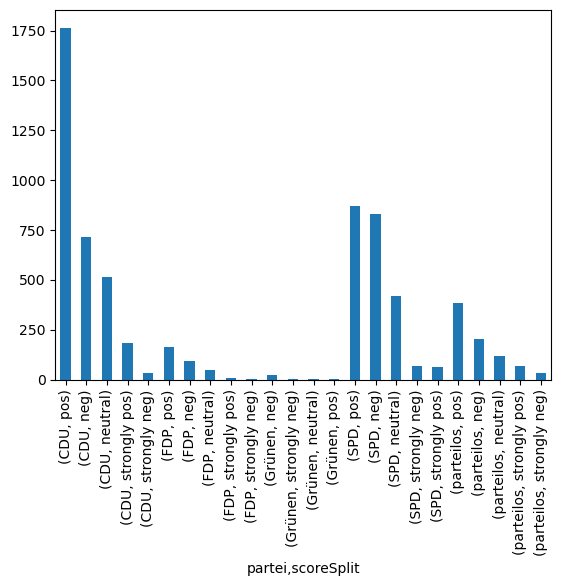

In [33]:
subgroups = speeches.groupby('partei').scoreSplit.value_counts()
subgroups.plot.bar()
plt.show()

This is a bit hard to compare across because of the uneven distribution, so let's look at the normalized version.

In [34]:
#To normalize this because the distribution is uneven...
speeches.groupby('partei').scoreSplit.value_counts(normalize=True)

partei     scoreSplit  
CDU        pos             0.549331
           neg             0.222845
           neutral         0.160286
           strongly pos    0.056956
           strongly neg    0.010582
FDP        pos             0.514107
           neg             0.294671
           neutral         0.156740
           strongly pos    0.025078
           strongly neg    0.009404
Grünen     neg             0.666667
           strongly neg    0.151515
           neutral         0.090909
           pos             0.090909
SPD        pos             0.385778
           neg             0.368889
           neutral         0.187111
           strongly neg    0.030667
           strongly pos    0.027556
parteilos  pos             0.476368
           neg             0.253731
           neutral         0.144279
           strongly pos    0.084577
           strongly neg    0.041045
Name: scoreSplit, dtype: float64

<Axes: ylabel='partei'>

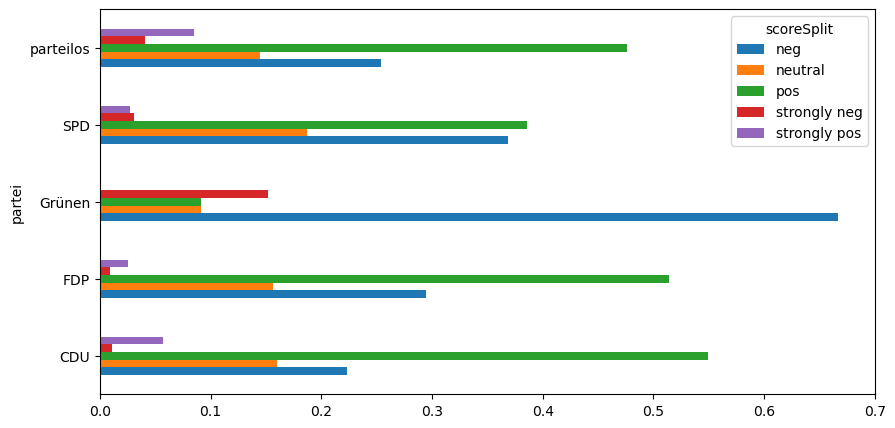

In [35]:
speeches.groupby('partei').scoreSplit.value_counts(normalize=True).unstack().plot.barh(figsize=(10,5))

For all of the parties except the Greens(Grünen) pos was most common. The Greens have an unusually high percentage of neg speeches aand they have the highest percentage of strongly neg speeches. 

In [36]:
cdu = speeches[speeches.partei == 'CDU'].sentimentScore
fdp = speeches[speeches.partei == 'FDP'].sentimentScore
grünen = speeches[speeches.partei == 'Grünen'].sentimentScore
spd = speeches[speeches.partei == 'SPD'].sentimentScore
parteilos = speeches[speeches.partei == 'parteilos'].sentimentScore
print(stats.f_oneway(cdu, fdp, grünen, spd, parteilos))

F_onewayResult(statistic=79.44527871090577, pvalue=6.092047544277175e-66)


The overall variation isn't crazy, but the p-value shows that the differences are pretty significant. Let's see how the variation changes between 2 parties alone

In [37]:
print(stats.f_oneway(cdu, parteilos))
print(stats.f_oneway(fdp, parteilos))
print(stats.f_oneway(grünen, parteilos))
print(stats.f_oneway(spd, parteilos))

F_onewayResult(statistic=3.0279854255811687, pvalue=0.08191619275256382)
F_onewayResult(statistic=2.0295231494161734, pvalue=0.15454732745109603)
F_onewayResult(statistic=38.946286833192985, pvalue=6.921654423906375e-10)
F_onewayResult(statistic=75.11470137228382, pvalue=7.083695054236845e-18)


In [38]:
print(stats.f_oneway(cdu, fdp))
print(stats.f_oneway(cdu, grünen))
print(stats.f_oneway(cdu, spd))

F_onewayResult(statistic=9.65324090243482, pvalue=0.0019051994170114646)
F_onewayResult(statistic=66.96089450690377, pvalue=3.9340193992114156e-16)
F_onewayResult(statistic=274.273531969164, pvalue=3.815149409571216e-60)


In [39]:
print(stats.f_oneway(fdp, grünen))
print(stats.f_oneway(fdp, spd))

F_onewayResult(statistic=50.883828080968, pvalue=5.6672146413683e-12)
F_onewayResult(statistic=20.723010751038693, pvalue=5.554781003921061e-06)


In [40]:
print(stats.f_oneway(spd, grünen))

F_onewayResult(statistic=27.215060836384346, pvalue=1.9845900534114756e-07)


It looks like the CDU and SPD have the most variation in sentiment, and FDP and parteilos are the most similar.
Let's do the same look across offices(amt)

In [41]:
speeches['amt'].value_counts()

Bundesregierung        2963
Bundespräsident        2025
AuswärtigesAmt         1254
Bundestagspräsident     377
Name: amt, dtype: int64

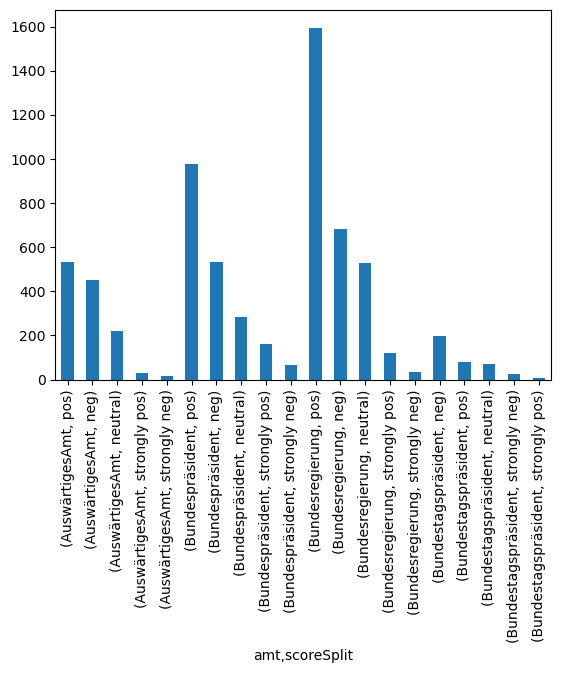

In [42]:
subgroups = speeches.groupby('amt').scoreSplit.value_counts()
subgroups.plot.bar()
plt.show()

<Axes: ylabel='amt'>

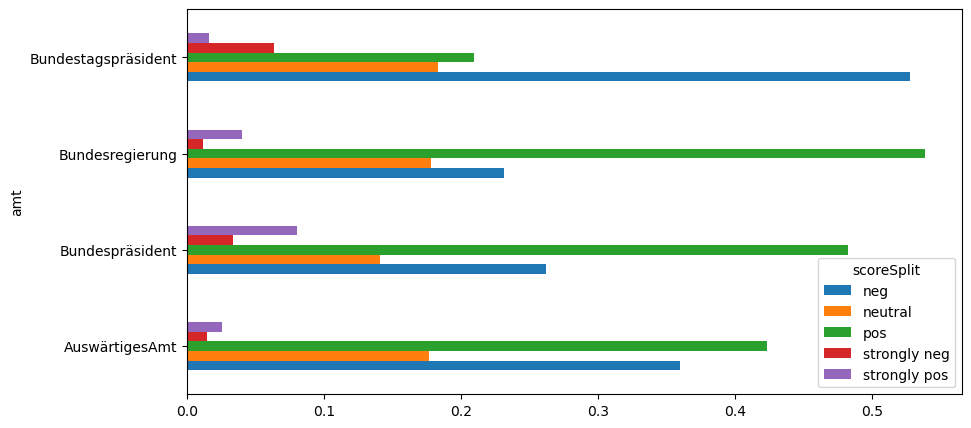

In [43]:
speeches.groupby('amt').scoreSplit.value_counts(normalize=True).unstack().plot.barh(figsize=(10,5))

In [44]:
aAmt = speeches[speeches.amt == 'AuswärtigesAmt'].sentimentScore
bPres = speeches[speeches.amt == 'Bundespräsident'].sentimentScore
bReg = speeches[speeches.amt == 'Bundesregierung'].sentimentScore
bTagPres = speeches[speeches.amt == 'Bundestagspräsident'].sentimentScore

print(stats.f_oneway(aAmt, bPres, bReg, bTagPres))

F_onewayResult(statistic=88.70079274501767, pvalue=2.858557120376158e-56)


In [45]:
print(stats.f_oneway(aAmt, bPres))
print(stats.f_oneway(aAmt, bReg))
print(stats.f_oneway(aAmt, bTagPres))

F_onewayResult(statistic=43.900747724345756, pvalue=4.022957762847872e-11)
F_onewayResult(statistic=84.09172288861325, pvalue=7.21587929641205e-20)
F_onewayResult(statistic=79.44372501821499, pvalue=1.2982429237621644e-18)


In [46]:
print(stats.f_oneway(bPres, bReg))
print(stats.f_oneway(bPres, bTagPres))

F_onewayResult(statistic=1.007809968452521, pvalue=0.31547679137804935)
F_onewayResult(statistic=148.6769565158858, pvalue=3.17462770726498e-33)


In [47]:
print(stats.f_oneway(bReg, bTagPres))

F_onewayResult(statistic=250.53548757710058, pvalue=1.8125040739634177e-54)


It looks like the overall variation is statistically significant. The bundesregierung and the bundestagpräsident vary the most, while the bundespräsident and bundesregierung vary the least.

## Word Analysis
Let's take a look at what words are influencing the positive and negative weights the most. I'm going to start by splitting the speeches up by sentiment

In [48]:
# dataframes by sentiment
pos_df = speeches[speeches.scoreSplit == 'pos']
neg_df = speeches[speeches.scoreSplit=='neg']
sneg_df = speeches[speeches.scoreSplit=='strongly neg']
spos_df = speeches[speeches.scoreSplit=='strongly pos']
neu_df = speeches[speeches.scoreSplit=='neutral']
pos_df.head()

,person,datum,partei,gender,titel,position,amt,scoreSplit,url,rohtext,wordToks,wordCt,sents,sentCt,bigrams,types,year,scoredWords,sentimentScore
0,Joachim Gauck,2016-05-02,parteilos,M,Begegnungsreise mit dem Diplomatischen Korps,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,Wie viele Botschafterinnen und Botschafter hab...,"[Wie, viele, Botschafterinnen, und, Botschafte...",1653,[Wie viele Botschafterinnen und Botschafter ha...,87,"[(Wie, viele), (viele, Botschafterinnen), (Bot...","{1815, Grenzen, Deutschland, sie, ;, 19, grenz...",2016,"[Liebe, besonderen, gemeinsamen, Diplomatische...",0.030801
1,Joachim Gauck,2014-02-26,parteilos,M,Empfang des slowakischen Präsidenten,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,"Besuche sind eine schöne Gelegenheit, Gemeinsa...","[Besuche, sind, eine, schöne, Gelegenheit, ,, ...",833,"[Besuche sind eine schöne Gelegenheit, Gemeins...",43,"[(Besuche, sind), (sind, eine), (eine, schöne)...","{Deutschland, sie, Truppen, 19, es, Biographie...",2014,"[schöne, Freunden, verbindet, Versöhnung, veru...",0.038123
2,Horst Köhler,2009-03-13,CDU,M,Grußwort von Bundespräsident Horst Köhler an d...,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,"Majestät, ich danke Ihnen für Ihre Worte des M...","[Majestät, ,, ich, danke, Ihnen, für, Ihre, Wo...",784,"[Majestät, ich danke Ihnen für Ihre Worte des ...",50,"[(Majestät, ,), (,, ich), (ich, danke), (danke...","{Deutschland, Damen, es, würden, Kohl, Binnenm...",2009,"[Majestät, danke, Mitgefühls, schrecklichen, A...",0.016996
4,Horst Köhler,2009-12-06,CDU,M,Grußwort von Bundespräsident Horst Köhler bei ...,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,Herzlich willkommen in Schloss Bellevue. Meine...,"[Herzlich, willkommen, in, Schloss, Bellevue, ...",1149,"[Herzlich willkommen in Schloss Bellevue., Mei...",49,"[(Herzlich, willkommen), (willkommen, in), (in...","{Bedingungen, Deutschland, sie, einfach, akzep...",2009,"[freuen, besondere, getrennt, glücklichen, Fre...",0.072115
7,Joachim Gauck,2012-05-21,parteilos,M,Festakt zur Eröffnung der Special Olympics Mün...,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,Olympische Spiele in München! Man muss es gar ...,"[Olympische, Spiele, in, München, !, Man, muss...",1529,"[Olympische Spiele in München!, Man muss es ga...",69,"[(Olympische, Spiele), (Spiele, in), (in, Münc...","{Heiterkeit, Deutschland, sie, anfangen, einfa...",2012,"[Fest, blutigen, gnadenlosen, Terror, miteinan...",0.060820


In [49]:
spos = spos_df.scoredWords.tolist()
sneg = sneg_df.scoredWords.tolist()
sposWords = [word for sublist in spos for word in sublist]
snegWords = [word for sublist in sneg for word in sublist]
print(sposWords[:10])
print(snegWords[:10])

['Freude', 'Freude', 'nützen', 'voranbringen', 'schätze', 'Verantwortung', 'schönste', 'angemessenste', 'Freiheit', 'freue']
['freien', 'Bedrohung', 'Ermordung', 'Freunden', 'hoffe', 'Freunden', 'Interesse', 'historischen', 'Interesse', 'Unbehagen']


Some of the words in the strongly pos speeches are 'joy', 'use', 'dear', 'responsibility', 'beautiful', 'freedom'

Some of the words in the strongly neg speeches are 'to free', 'threat', 'murder', 'Friends', 'to hope', 'interests', 'historical'

From this, we can see that some make sense as having a related connotation, but some words like 'friends'(freunden) might have a positive sentiment score but when it comes to the overall score of the speech, these positive words are overruled by other negative words in the speech. Now, I'm going to look at what words are most common in the strongly pos/neg speeches

In [50]:
pCounts = Counter(sposWords)
sposMC = pCounts.most_common(20)
print(sposMC)
nCounts = Counter(snegWords)
snegMC = nCounts.most_common(20)
print(snegMC)

[('freue', 310), ('Freude', 231), ('Erfolg', 185), ('danke', 152), ('liebe', 144), ('Engagement', 125), ('Mut', 124), ('guten', 122), ('Zusammenarbeit', 116), ('feiern', 101), ('lernen', 97), ('danken', 93), ('wichtige', 92), ('miteinander', 91), ('Bildung', 89), ('Freiheit', 83), ('freuen', 81), ('Freundschaft', 80), ('Tradition', 75), ('Liebe', 73)]
[('Krieg', 337), ('Gewalt', 242), ('Frieden', 156), ('Verantwortung', 148), ('Freiheit', 148), ('Leid', 143), ('Schuld', 135), ('Krieges', 107), ('Unrecht', 96), ('Angst', 91), ('Kampf', 78), ('Hass', 75), ('Tod', 72), ('Trauer', 72), ('verloren', 71), ('Gefahr', 69), ('Auseinandersetzung', 66), ('Gedenken', 66), ('Sicherheit', 61), ('Wahrheit', 60)]


It looks like, for the most part, the most common words for pos and neg seem like they match their grouping. Some words like 'Frieden'(peace) seem misplaced, but they might be used in a context saying "there's no peace" or something similar. Lets look at the weights of these common words.

In [51]:
spos20 = [w for w,c in sposMC]
sneg20 = [w for w,c in snegMC]
print("Most common 20 words in strongly positive and their weights::")
for doc in nlp.pipe(spos20):
    print([(token.text, token._.sentiws) for token in doc])

print()
print("Most common 20 words in strongly negative and their weights:")
for doc in nlp.pipe(sneg20):
    print([(token.text, token._.sentiws) for token in doc])

Most common 20 words in strongly positive and their weights::
[('freue', 0.2198)]
[('Freude', 0.6502)]
[('Erfolg', 0.3446)]
[('danke', None)]
[('liebe', None)]
[('Engagement', 0.2157)]
[('Mut', 0.6093)]
[('guten', None)]
[('Zusammenarbeit', 0.0893)]
[('feiern', 0.494)]
[('lernen', 0.2492)]
[('danken', 0.191)]
[('wichtige', 0.3822)]
[('miteinander', 0.3697)]
[('Bildung', 0.004)]
[('Freiheit', 0.004)]
[('freuen', 0.2198)]
[('Freundschaft', 0.2059)]
[('Tradition', 0.004)]
[('Liebe', 0.0985)]

Most common 20 words in strongly negative and their weights:
[('Krieg', -0.5364)]
[('Gewalt', -0.5363)]
[('Frieden', 0.004)]
[('Verantwortung', 0.004)]
[('Freiheit', 0.004)]
[('Leid', -0.5056)]
[('Schuld', -0.9686)]
[('Krieges', -0.5364)]
[('Unrecht', -0.5086)]
[('Angst', -0.514)]
[('Kampf', -0.5372)]
[('Hass', -0.5014)]
[('Tod', -0.0697)]
[('Trauer', -0.0048)]
[('verloren', -0.393)]
[('Gefahr', -1.0)]
[('Auseinandersetzung', -0.0603)]
[('Gedenken', 0.004)]
[('Sicherheit', 0.004)]
[('Wahrheit', 0.004

## Diachronic Analysis

Now, let's look at how sentiment changed over time. These speeches span from 1984-2017, so there have been a lot of political events in those years that may have affected the sentiment of speeches across time.

In [52]:
cdu = speeches[speeches.partei == 'CDU']
fdp = speeches[speeches.partei == 'FDP']
grünen = speeches[speeches.partei == 'Grünen']
spd = speeches[speeches.partei == 'SPD']
parteilos = speeches[speeches.partei == 'parteilos']

<Axes: xlabel='year', ylabel='sentimentScore'>

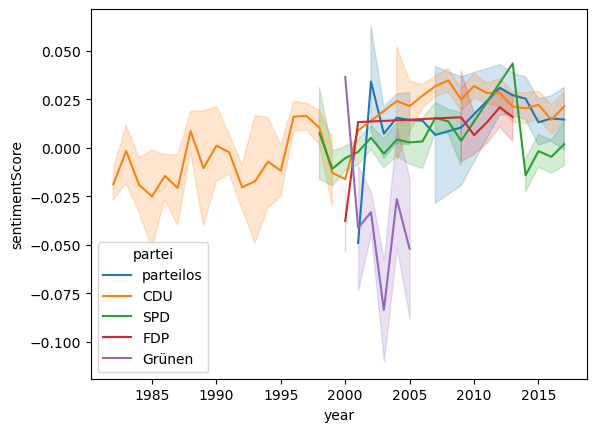

In [53]:
sns.lineplot(data=speeches, x=speeches['year'], y=speeches['sentimentScore'], hue=speeches['partei'])

This shows the changes of all political parties at once, but it's not very easy to decipher when they're on top of each other. Below they are separated per party.

<Axes: xlabel='year', ylabel='sentimentScore'>

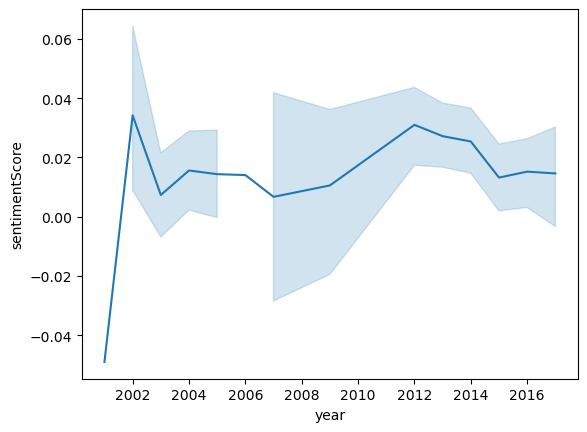

In [54]:
sns.lineplot(data=parteilos, x=parteilos['year'], y=parteilos['sentimentScore'])

<Axes: xlabel='year', ylabel='sentimentScore'>

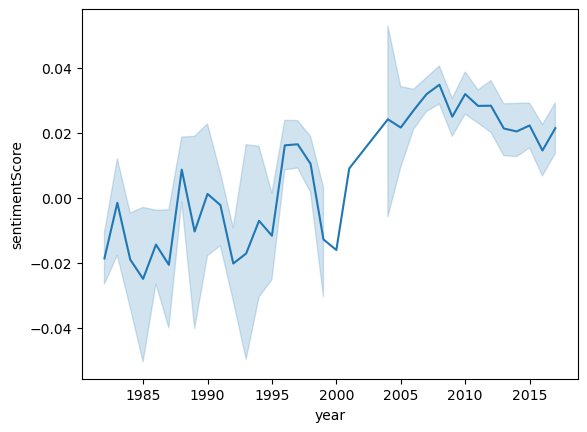

In [55]:
sns.lineplot(data=cdu, x=cdu['year'], y=cdu['sentimentScore'])

The CDU is one of Germany's oldest political parties. It existed in West Germany before the reunification in 1990. It has also stayed one of Germany's largest parties. This is the only party that has speech data before 1997. We can see that following the reunification, sentiment scores dropped overall. Around 2001, there is a more consistent rise in scores. 

<Axes: xlabel='year', ylabel='sentimentScore'>

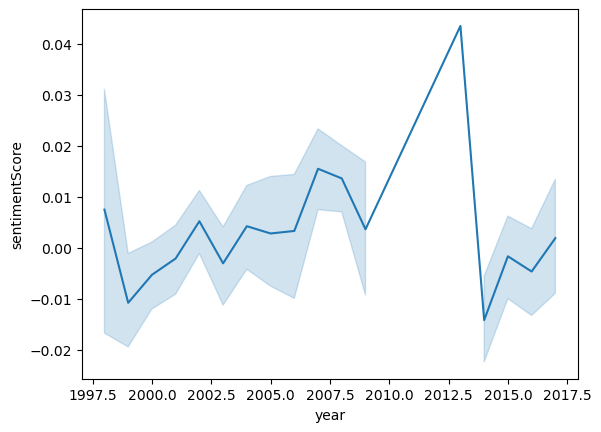

In [56]:
sns.lineplot(data=spd, x=spd['year'], y=spd['sentimentScore'])

The SPD is another prominent party in the German government that was around before reunification. The sentiment seems to fluctuate around somewhat negative, other than the stark jump in sentiment around 2009-2013.

<Axes: xlabel='year', ylabel='sentimentScore'>

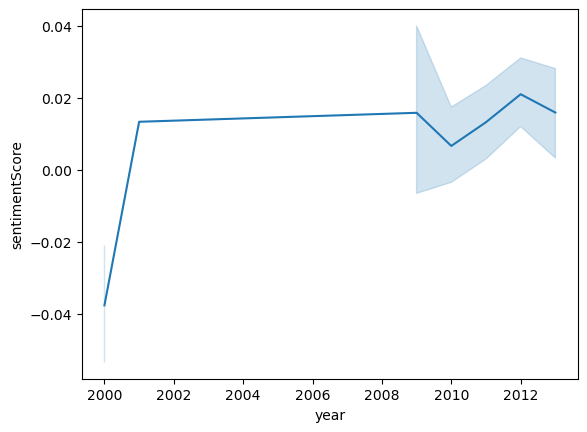

In [57]:
sns.lineplot(data=fdp, x=fdp['year'], y=fdp['sentimentScore'])

The FDP doesn't have a very wide range of time, and it stays relatively consistent around .18 other than the first data point that's much lower.

<Axes: xlabel='year', ylabel='sentimentScore'>

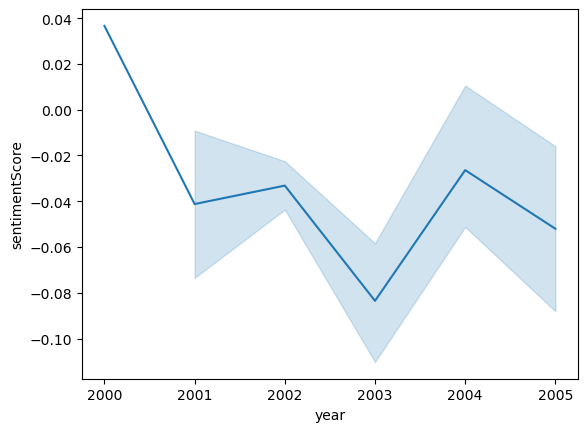

In [58]:
sns.lineplot(data=grünen, x=grünen['year'], y=grünen['sentimentScore'])

The green party has an extremely small time frame compared to the other parties. This party was only founded in 1993, making it a relatively new party. It starts with a pretty positive point, then decreases and remains in the negatives. 